In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import cv2
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

2023-06-22 16:02:39.845465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Load npz file
The features stored in a *.npz* file and here it will be loaded

In [179]:
f1 = np.load("Features2D/npz/Features1.npz")

In [180]:
spec1 = f1['spec'] #(898,1025,1099)
mfcc1 = f1['mfcc'] #(898,20,1099)
mel1 = f1['mel']#(898,128,1099)
y1 = f1['target']

In [181]:
f2 = np.load("Features2D/npz/Features2.npz")

In [182]:
spec2 = f2['spec'] #(400,1025,1099)
mfcc2 = f2['mfcc'] #(400,20,1099)
mel2 = f2['mel']#(400,128,1099)
y2 = f2['target']

## 3. Data preprocessing
### 3.1 Resize the data

In [17]:
mfcc1_resized = np.empty((mfcc1.shape[0], 120, 600))
for i in range(0,898):
    mfcc1_resized[i] = cv2.resize(mfcc1[i],(600,120))

mfcc2_resized = np.empty((mfcc2.shape[0], 120, 600))
for i in range(0,400):
    mfcc2_resized[i] = cv2.resize(mfcc2[i],(600,120))

In [60]:
spec1_resized = np.empty((spec1.shape[0], 200, 200))
for i in range(0,898):
    spec1_resized[i] = cv2.resize(spec1[i],(200,200))

spec2_resized = np.empty((spec2.shape[0], 200, 200))
for i in range(0,400):
    spec2_resized[i] = cv2.resize(spec2[i],(200,200))

In [75]:
mel1_resized = np.empty((mel1.shape[0], 300, 400))
for i in range(0,898):
    mel1_resized[i] = cv2.resize(mel1[i],(400,300))

mel2_resized = np.empty((mel2.shape[0], 300, 400))
for i in range(0,400):
    mel2_resized[i] = cv2.resize(mel2[i],(400,300))

### 3.2 Train Test Split

In [20]:
mfcc1_train,mfcc1_test,y1_train,y1_test = train_test_split(mfcc1_resized,y1, 
                                                   train_size = 0.8, 
                                                   random_state = 13, 
                                                   stratify= y1)
mfcc2_train,mfcc2_test,y2_train,y2_test = train_test_split(mfcc2_resized,y2, 
                                                   train_size = 0.9, 
                                                   random_state = 13, 
                                                   stratify= y2)

In [21]:
np.savez_compressed("Features2D/npz_new/mfcc1_train_test.npz",
                    mfcc_train = mfcc1_train, 
                    mfcc_test = mfcc1_test, 
                    y_train = y1_train, 
                    y_test= y1_test)

np.savez_compressed("Features2D/npz_new/mfcc2_train_test.npz",
                    mfcc_train = mfcc2_train, 
                    mfcc_test = mfcc2_test, 
                    y_train = y2_train, 
                    y_test = y2_test)

In [70]:
spec1_train,spec1_test,y1_train,y1_test = train_test_split(spec1_resized,y1, 
                                                           train_size = 0.8,  
                                                           random_state = 13, 
                                                           stratify = y1)
spec2_train,spec2_test,y2_train,y2_test = train_test_split(spec2_resized,y2, 
                                                           train_size = 0.9, 
                                                           random_state = 13, 
                                                           stratify = y2)

In [71]:
np.savez_compressed("Features2D/npz_new/spec1_train_test.npz",
                    spec_train = spec1_train, 
                    spec_test = spec1_test, 
                    y_train = y1_train, 
                    y_test= y1_test)

np.savez_compressed("Features2D/npz_new/spec2_train_test.npz",
                    spec_train = spec2_train, 
                    spec_test = spec2_test, 
                    y_train = y2_train, 
                    y_test = y2_test)

In [123]:
mel1_train,mel1_test,y1_train,y1_test = train_test_split(mel1_resized,y1, 
                                                           train_size = 0.8,  
                                                           random_state = 13, 
                                                           stratify = y1)
mel2_train,mel2_test,y2_train,y2_test = train_test_split(mel2_resized,y2, 
                                                           train_size = 0.9,  
                                                           random_state = 13, 
                                                           stratify = y2)

In [124]:
np.savez_compressed("Features2D/npz_new/mel1_train_test.npz",
                    mel_train = mel1_train, 
                    mel_test = mel1_test, 
                    y_train = y1_train, 
                    y_test = y1_test)

np.savez_compressed("Features2D/npz_new/mel2_train_test.npz",
                    mel_train = mel2_train, 
                    mel_test = mel2_test, 
                    y_train = y2_train, 
                    y_test = y2_test)

## 4. Classification

In [4]:
# Train the model
def modelBuilder3L(X_train,
                   f1,k1,a1,
                   mw1,mh1,sw1,sh1,
                   f2,k2,a2,
                   mw2,mh2,sw2,sh2,
                   f3,k3,a3,
                   mw3,mh3,sw3,sh3,
                   d1,dr1,da1,r1,
                   d2,dr2,da2,r2,
                   num):
    
    '''
    args:
    
    X_train: training data
    f1,k1,a1: num of filters, filter size and activation func of 1st conv2D layer
    mr1,mc1,sr1,sc1: filter size and strides of 1st MaxPooling2D layer
    f2,k2,a2: num of filters, filter size and activation func of 2nd conv2D layer
    mr2,mc2,sr2,sc2: filter size and strides of 2nd MaxPooling2D layer
    f3,k3,a3: num of filters, filter size and activation func of 3rd conv2D layer
    mr3,sc3,sr3,sc3: filter size and strides of 3rd MaxPooling2D layer
    d1,dr1,da1, r1: num of units, dropout, activation func and regularizer para of 1st fully connected layer
    d2,dr2,da2, r2: num of units, dropout, activation func and regularizer para of 2nd fully connected layer
    num: integer for distinguishing different model
    
    return:
    model
    
    '''
    
    N,row,col,Nc = X_train.shape
    
    model = Sequential(name = "CNN2D_"+str(num))
    #L1
    model.add(Conv2D(f1,(k1,k1),activation = a1,input_shape = (row,col,Nc), padding = 'same', name = 'Conv2D_1'))
    model.add(MaxPooling2D((mw1,mh1), strides = (sw1,sh1), padding = 'same', name = 'MaxPooling2D_1'))
    model.add(BatchNormalization(name = "BN1"))
    
    #L2
    model.add(Conv2D(f2,(k2,k2), activation = a2, padding = 'same',name = 'Conv2D_2'))
    model.add(MaxPooling2D((mw2,mh2),strides = (sw2,sh2), padding = 'same', name = 'MaxPooling2D_2'))
    model.add(BatchNormalization(name = "BN2"))

    #L3
    model.add(Conv2D(f3,(k3,k3), activation = a3, padding = 'same',name = 'Conv2D_3'))
    model.add(MaxPooling2D((mw3,mh3), strides = (sw3,sh3), padding = 'same', name = 'MaxPooling2D_3'))
    model.add(BatchNormalization(name = "BN3"))
   
    #Flatten layer
    model.add(Flatten(name = 'Flatten'))
    #FC4
    model.add(Dense(d1, activation = da1, kernel_regularizer = tf.keras.regularizers.L2(r1), name='Dense1'))
    model.add(Dropout(dr1, name = "Dropout1"))
    #FC5
    model.add(Dense(d2, activation = da2, kernel_regularizer = tf.keras.regularizers.L2(r2), name='Dense2'))
    model.add(Dropout(dr2, name = "Dropout2"))
    #Softmax layer
    model.add(Dense(4, activation ='softmax', name='Softmax'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer= optimizer, loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    
    return model

### 4.1 MFCC

In [27]:
# Load MFCC data set
mfcc1_file = np.load("Features2D/npz_new/mfcc1_train_test.npz")

mfcc1_train = mfcc1_file['mfcc_train']
y1_train = mfcc1_file['y_train']

# validation set
mfcc1_train,mfcc1_val,y1_train,y1_val = train_test_split(mfcc1_train,y1_train, 
                                                         train_size = 0.8,  
                                                         random_state = 13, 
                                                         stratify= y1_train)

In [28]:
# Feature Scaling
mfcc1_train_scaled = (mfcc1_train - np.mean(mfcc1_train))/np.std(mfcc1_train)
mfcc1_val_scaled = (mfcc1_val - np.mean(mfcc1_val))/np.std(mfcc1_val)

In [29]:
# Reshape the data
N,row,col = mfcc1_train_scaled.shape
mfcc1_train_reshaped = mfcc1_train_scaled.reshape((N,row,col,1))
N,row,col = mfcc1_val_scaled.shape
mfcc1_val_reshaped = mfcc1_val_scaled.reshape((N,row,col,1))

In [30]:
f1,k1,a1 = 8,3,'relu'
mw1,mh1,sw1,sh1 = 2,3,2,2
f2,k2,a2 = 8,3,'relu'
mw2,mh2,sw2,sh2 = 2,3,2,2
f3,k3,a3 = 16,3,'relu'
mw3,mh3,sw3,sh3 = 4,6,2,2
d1,dr1,da1,r1 = 64,0.2,'relu',0.2
d2,dr2,da2,r2 = 32,0.2,'relu',0.2
num = 1

model1 = modelBuilder3L(mfcc1_train_reshaped,
                        f1,k1,a1,
                        mw1,mh1,sw1,sh1,
                        f2,k2,a2,
                        mw2,mh2,sw2,sh2,
                        f3,k3,a3,
                        mw3,mh3,sw3,sh3,
                        d1,dr1,da1,r1,
                        d2,dr2,da2,r2,
                        num)

Model: "CNN2D_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 120, 600, 8)       80        
                                                                 
 MaxPooling2D_1 (MaxPooling2  (None, 60, 300, 8)       0         
 D)                                                              
                                                                 
 BN1 (BatchNormalization)    (None, 60, 300, 8)        32        
                                                                 
 Conv2D_2 (Conv2D)           (None, 60, 300, 8)        584       
                                                                 
 MaxPooling2D_2 (MaxPooling2  (None, 30, 150, 8)       0         
 D)                                                              
                                                                 
 BN2 (BatchNormalization)    (None, 30, 150, 8)        32  

In [31]:
model1.fit(mfcc1_train_reshaped,y1_train,validation_data=(mfcc1_val_reshaped,y1_val),batch_size=20,epochs=80)

Epoch 1/80
29/29 [==============================] - 12s 337ms/step - loss: 32.7083 - accuracy: 0.2892 - val_loss: 29.3422 - val_accuracy: 0.3611
Epoch 2/80
29/29 [==============================] - 9s 319ms/step - loss: 26.5807 - accuracy: 0.3676 - val_loss: 23.8135 - val_accuracy: 0.4375
Epoch 3/80
29/29 [==============================] - 10s 350ms/step - loss: 21.6396 - accuracy: 0.4634 - val_loss: 19.6903 - val_accuracy: 0.4097
Epoch 4/80
29/29 [==============================] - 10s 338ms/step - loss: 17.9802 - accuracy: 0.4774 - val_loss: 16.5619 - val_accuracy: 0.4306
Epoch 5/80
29/29 [==============================] - 9s 293ms/step - loss: 15.2541 - accuracy: 0.5261 - val_loss: 14.4043 - val_accuracy: 0.3056
Epoch 6/80
29/29 [==============================] - 9s 308ms/step - loss: 13.2714 - accuracy: 0.5383 - val_loss: 12.6711 - val_accuracy: 0.3333
Epoch 7/80
29/29 [==============================] - 9s 310ms/step - loss: 11.7736 - accuracy: 0.5767 - val_loss: 11.4066 - val_accura

In [5]:
mfcc2_file = np.load("Features2D/npz_new/mfcc2_train_test.npz")
mfcc2_train = mfcc2_file['mfcc_train']
y2_train = mfcc2_file['y_train']

mfcc2_train,mfcc2_val,y2_train,y2_val = train_test_split(mfcc2_train,y2_train, 
                                                         train_size = 0.8,  
                                                         random_state = 13, 
                                                         stratify= y2_train)

In [6]:
# Feature Scaling
mfcc2_train_scaled = (mfcc2_train - np.mean(mfcc2_train))/np.std(mfcc2_train)
mfcc2_val_scaled = (mfcc2_val - np.mean(mfcc2_val))/np.std(mfcc2_val)

In [7]:
# Reshape the data
N,row,col = mfcc2_train_scaled.shape
mfcc2_train_reshaped = mfcc2_train_scaled.reshape((N,row,col,1))
N,row,col = mfcc2_val_scaled.shape
mfcc2_val_reshaped = mfcc2_val_scaled.reshape((N,row,col,1))

In [8]:
f1,k1,a1 = 8,3,'relu'
mw1,mh1,sw1,sh1 = 2,3,1,1
f2,k2,a2 = 8,3,'relu',
mw2,mh2,sw2,sh2 = 2,3,2,2
f3,k3,a3 = 8,3,'relu',
mw3,mh3,sw3,sh3 = 2,3,2,2
d1,dr1,da1,r1 = 64,0.2,'relu',0.2
d2,dr2,da2,r2 = 32,0.2,'relu',0.2
num = 2
model2 = modelBuilder3L(mfcc2_train_reshaped,
                        f1,k1,a1,
                        mw1,mh1,sw1,sh1,
                        f2,k2,a2,
                        mw2,mh2,sw2,sh2,
                        f3,k3,a3,
                        mw3,mh3,sw3,sh3,
                        d1,dr1,da1,r1,
                        d2,dr2,da2,r2,
                        num)

Model: "CNN2D_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 120, 600, 8)       80        
                                                                 
 MaxPooling2D_1 (MaxPooling2  (None, 120, 600, 8)      0         
 D)                                                              
                                                                 
 BN1 (BatchNormalization)    (None, 120, 600, 8)       32        
                                                                 
 Conv2D_2 (Conv2D)           (None, 120, 600, 8)       584       
                                                                 
 MaxPooling2D_2 (MaxPooling2  (None, 60, 300, 8)       0         
 D)                                                              
                                                                 
 BN2 (BatchNormalization)    (None, 60, 300, 8)        32  

In [9]:
history2 = model2.fit(mfcc2_train_reshaped,y2_train,validation_data=(mfcc2_val_reshaped,y2_val),batch_size=20,epochs=80)

Epoch 1/80
15/15 [==============================] - 16s 932ms/step - loss: 34.2489 - accuracy: 0.3472 - val_loss: 32.2614 - val_accuracy: 0.3611
Epoch 2/80
15/15 [==============================] - 12s 799ms/step - loss: 30.3568 - accuracy: 0.5764 - val_loss: 28.8359 - val_accuracy: 0.4028
Epoch 3/80
15/15 [==============================] - 12s 780ms/step - loss: 26.8645 - accuracy: 0.6771 - val_loss: 25.6699 - val_accuracy: 0.3889
Epoch 4/80
15/15 [==============================] - 13s 897ms/step - loss: 23.7813 - accuracy: 0.7257 - val_loss: 22.9432 - val_accuracy: 0.3333
Epoch 5/80
15/15 [==============================] - 12s 800ms/step - loss: 21.2451 - accuracy: 0.7431 - val_loss: 20.6890 - val_accuracy: 0.3194
Epoch 6/80
15/15 [==============================] - 13s 867ms/step - loss: 19.0415 - accuracy: 0.8229 - val_loss: 18.8156 - val_accuracy: 0.2778
Epoch 7/80
15/15 [==============================] - 12s 797ms/step - loss: 17.2505 - accuracy: 0.8229 - val_loss: 17.2433 - val_ac

Text(0, 0.5, 'loss')

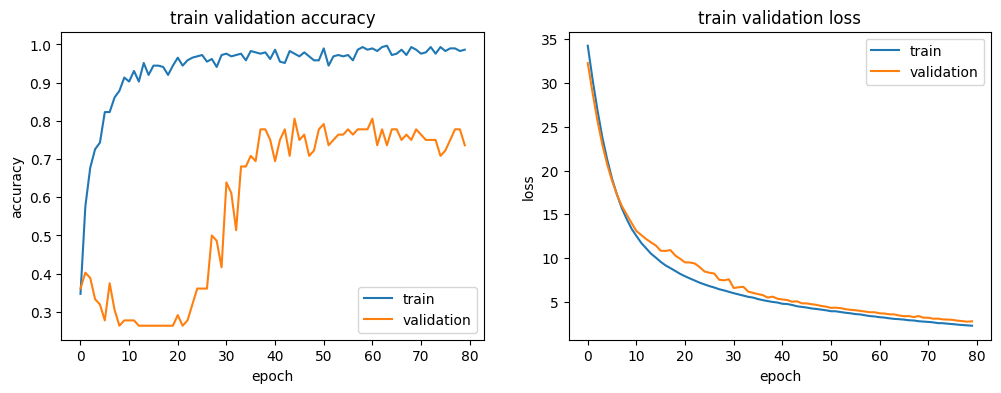

In [10]:
# Train and Validation accuracy and loss
f = plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.title('train validation accuracy')
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(1,2,2)
plt.title('train validation loss')
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

In [11]:
mfcc2_test = mfcc2_file['mfcc_test']
y2_test_mfcc = mfcc2_file['y_test']

In [12]:
# Feature Scaling
mfcc2_test_scaled = (mfcc2_test - np.mean(mfcc2_test))/np.std(mfcc2_test)

# Reshape the data
N,row,col = mfcc2_test_scaled.shape
mfcc2_test_reshaped = mfcc2_test_scaled.reshape((N,row,col,1))

In [13]:
y1_prob = model2.predict(mfcc2_test_reshaped)
y1_pred = np.argmax(y1_prob, axis = -1)

2/2 [==============================] - 1s 90ms/step


In [14]:
# Accuracy
acc1_2d = round(accuracy_score(y1_pred,y2_test_mfcc),2)

In [15]:
# Confusion Matrix
cm_mfcc = confusion_matrix(y2_test_mfcc,y1_pred)
cm_2d_mfcc = ConfusionMatrixDisplay(confusion_matrix = cm_mfcc, display_labels = ['Angry', 'Happy', 'Relaxed', 'Sad'])

              precision    recall  f1-score   support

       Angry       0.91      1.00      0.95        10
       Happy       1.00      0.90      0.95        10
     Relaxed       0.91      1.00      0.95        10
         Sad       1.00      0.90      0.95        10

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



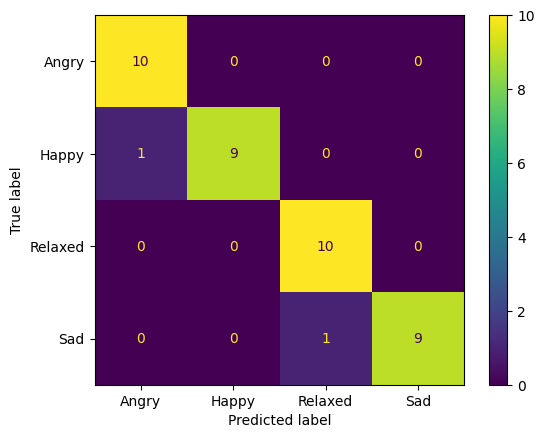

In [16]:
print(classification_report(y2_test_mfcc, y1_pred, target_names = ['Angry', 'Happy', 'Relaxed', 'Sad']))
cm_2d_mfcc.plot()
plt.show()

### 4.2 Spectrogram

In [215]:
# Load Spectrogram data set
spec1_file = np.load("Features2D/npz_new/spec1_train_test.npz")

spec1_train = spec1_file['spec_train']
y1_train = spec1_file['y_train']

spec1_train,spec1_val,y1_train,y1_val = train_test_split(spec1_train,y1_train, 
                                                         train_size = 0.8,
                                                         random_state = 13, 
                                                         stratify= y1_train)

In [216]:
# Feature Scaling
spec1_train_scaled = spec1_train / np.amax(spec1_train)
spec1_val_scaled = spec1_val / np.amax(spec1_val)

In [217]:
# Reshape the data
N,row,col = spec1_train_scaled.shape
spec1_train_reshaped = spec1_train_scaled.reshape((N,row,col,1))

N,row,col = spec1_val_scaled.shape
spec1_val_reshaped = spec1_val_scaled.reshape((N,row,col,1))

In [218]:
f1,k1,a1 = 8,3,'relu'
mw1,mh1,sw1,sh1 = 3,3,2,2
f2,k2,a2 = 8,3,'relu'
mw2,mh2,sw2,sh2 = 3,3,2,2
f3,k3,a3 = 16,3,'relu'
mw3,mh3,sw3,sh3 = 3,3,2,2
d1,dr1,da1,r1 = 64,0.2,'relu',0.2
d2,dr2,da2,r2 = 32,0.2,'relu',0.2
num = 3
model3 = modelBuilder3L(spec1_train_reshaped,
                        f1,k1,a1,
                        mw1,mh1,sw1,sh1,
                        f2,k2,a2,
                        mw2,mh2,sw2,sh2,
                        f3,k3,a3,
                        mw3,mh3,sw3,sh3,
                        d1,dr1,da1,r1,
                        d2,dr2,da2,r2,
                        num)

Model: "CNN2D_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 200, 200, 8)       80        
                                                                 
 MaxPooling2D_1 (MaxPooling2  (None, 100, 100, 8)      0         
 D)                                                              
                                                                 
 BN1 (BatchNormalization)    (None, 100, 100, 8)       32        
                                                                 
 Conv2D_2 (Conv2D)           (None, 100, 100, 8)       584       
                                                                 
 MaxPooling2D_2 (MaxPooling2  (None, 50, 50, 8)        0         
 D)                                                              
                                                                 
 BN2 (BatchNormalization)    (None, 50, 50, 8)         32  

In [219]:
model3.fit(spec1_train_reshaped,y1_train,validation_data=(spec1_val_reshaped,y1_val),batch_size=20,epochs=80)

Epoch 1/80
29/29 [==============================] - 7s 190ms/step - loss: 34.0231 - accuracy: 0.3868 - val_loss: 32.3687 - val_accuracy: 0.3611
Epoch 2/80
29/29 [==============================] - 5s 181ms/step - loss: 30.5039 - accuracy: 0.5244 - val_loss: 29.0630 - val_accuracy: 0.2500
Epoch 3/80
29/29 [==============================] - 5s 183ms/step - loss: 27.1824 - accuracy: 0.5749 - val_loss: 25.9538 - val_accuracy: 0.2500
Epoch 4/80
29/29 [==============================] - 5s 181ms/step - loss: 24.2182 - accuracy: 0.5627 - val_loss: 23.2449 - val_accuracy: 0.2500
Epoch 5/80
29/29 [==============================] - 6s 198ms/step - loss: 21.5283 - accuracy: 0.6307 - val_loss: 20.8789 - val_accuracy: 0.2708
Epoch 6/80
29/29 [==============================] - 6s 194ms/step - loss: 19.2251 - accuracy: 0.6533 - val_loss: 18.7558 - val_accuracy: 0.2569
Epoch 7/80
29/29 [==============================] - 6s 197ms/step - loss: 17.1796 - accuracy: 0.7195 - val_loss: 17.1436 - val_accuracy:

In [201]:
# Load Spectrogram data set
spec2_file = np.load("Features2D/npz_new/spec2_train_test.npz")

spec2_train = spec2_file['spec_train']
y2_train = spec2_file['y_train']
spec2_train,spec2_val,y2_train,y2_val = train_test_split(spec2_train,y2_train, 
                                                         train_size = 0.8, 
                                                         random_state = 13, 
                                                         stratify = y2_train)

In [202]:
# Feature Scaling
spec2_train_scaled = spec2_train / np.amax(spec2_train)
spec2_val_scaled = spec2_val / np.amax(spec2_val)

In [203]:
# Reshape the data
N,row,col = spec2_train_scaled.shape
spec2_train_reshaped = spec2_train_scaled.reshape((N,row,col,1))
N,row,col = spec2_val_scaled.shape
spec2_val_reshaped = spec2_val_scaled.reshape((N,row,col,1))

In [204]:
f1,k1,a1 = 8,3,'relu'
mw1,mh1,sw1,sh1 = 3,3,2,2
f2,k2,a2 = 8,3,'relu'
mw2,mh2,sw2,sh2 = 3,3,2,2
f3,k3,a3 = 16,3,'relu'
mw3,mh3,sw3,sh3 = 3,3,2,2
d1,dr1,da1,r1 = 64,0.2,'relu',0.2
d2,dr2,da2,r2 = 32,0.2,'relu',0.2
num = 4
model4 = modelBuilder3L(spec2_train_reshaped,
                        f1,k1,a1,
                        mw1,mh1,sw1,sh1,
                        f2,k2,a2,
                        mw2,mh2,sw2,sh2,
                        f3,k3,a3,
                        mw3,mh3,sw3,sh3,
                        d1,dr1,da1,r1,
                        d2,dr2,da2,r2,
                        num)

Model: "CNN2D_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 200, 200, 8)       80        
                                                                 
 MaxPooling2D_1 (MaxPooling2  (None, 100, 100, 8)      0         
 D)                                                              
                                                                 
 BN1 (BatchNormalization)    (None, 100, 100, 8)       32        
                                                                 
 Conv2D_2 (Conv2D)           (None, 100, 100, 8)       584       
                                                                 
 MaxPooling2D_2 (MaxPooling2  (None, 50, 50, 8)        0         
 D)                                                              
                                                                 
 BN2 (BatchNormalization)    (None, 50, 50, 8)         32  

In [205]:
history4 = model4.fit(spec2_train_reshaped,y2_train,validation_data=(spec2_val_reshaped,y2_val),batch_size=20,epochs=80)

Epoch 1/80
15/15 [==============================] - 5s 195ms/step - loss: 34.9831 - accuracy: 0.2917 - val_loss: 33.8139 - val_accuracy: 0.3194
Epoch 2/80
15/15 [==============================] - 3s 193ms/step - loss: 32.8367 - accuracy: 0.4549 - val_loss: 32.1098 - val_accuracy: 0.2500
Epoch 3/80
15/15 [==============================] - 3s 176ms/step - loss: 30.9863 - accuracy: 0.5139 - val_loss: 30.4457 - val_accuracy: 0.2500
Epoch 4/80
15/15 [==============================] - 3s 182ms/step - loss: 29.1360 - accuracy: 0.6215 - val_loss: 28.9281 - val_accuracy: 0.2500
Epoch 5/80
15/15 [==============================] - 3s 182ms/step - loss: 27.3405 - accuracy: 0.6597 - val_loss: 27.5884 - val_accuracy: 0.2500
Epoch 6/80
15/15 [==============================] - 3s 197ms/step - loss: 25.7756 - accuracy: 0.6389 - val_loss: 26.1383 - val_accuracy: 0.2500
Epoch 7/80
15/15 [==============================] - 3s 184ms/step - loss: 24.1618 - accuracy: 0.7396 - val_loss: 24.9490 - val_accuracy:

Epoch 58/80
15/15 [==============================] - 3s 193ms/step - loss: 3.4643 - accuracy: 0.9861 - val_loss: 3.8638 - val_accuracy: 0.8056
Epoch 59/80
15/15 [==============================] - 3s 180ms/step - loss: 3.3960 - accuracy: 0.9792 - val_loss: 3.7834 - val_accuracy: 0.8056
Epoch 60/80
15/15 [==============================] - 3s 176ms/step - loss: 3.3145 - accuracy: 0.9896 - val_loss: 3.7033 - val_accuracy: 0.8194
Epoch 61/80
15/15 [==============================] - 3s 181ms/step - loss: 3.2728 - accuracy: 0.9757 - val_loss: 3.6457 - val_accuracy: 0.7639
Epoch 62/80
15/15 [==============================] - 3s 177ms/step - loss: 3.2073 - accuracy: 0.9931 - val_loss: 3.6342 - val_accuracy: 0.8056
Epoch 63/80
15/15 [==============================] - 3s 186ms/step - loss: 3.1267 - accuracy: 0.9965 - val_loss: 3.5316 - val_accuracy: 0.7778
Epoch 64/80
15/15 [==============================] - 3s 176ms/step - loss: 3.0933 - accuracy: 0.9792 - val_loss: 3.5189 - val_accuracy: 0.7639

Text(0, 0.5, 'loss')

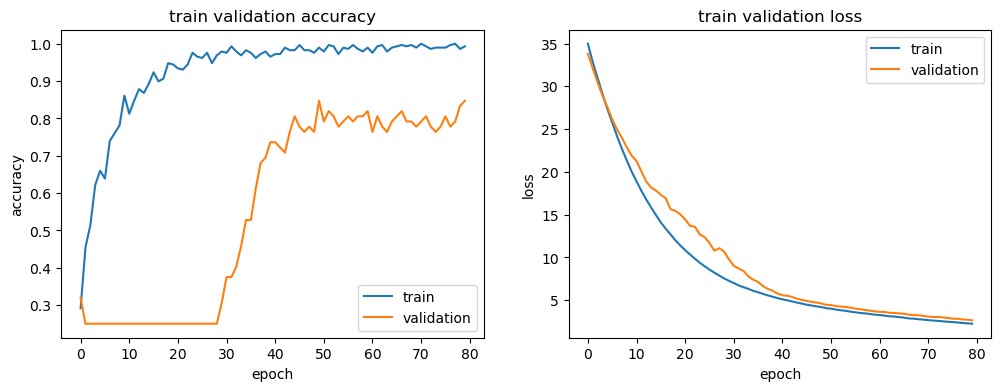

In [213]:
# Train and Validation accuracy and loss
f = plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.title('train validation accuracy')
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(1,2,2)
plt.title('train validation loss')
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

In [207]:
spec2_test = spec2_file['spec_test']
y2_test_spec = spec2_file['y_test']

In [208]:
# Feature Scaling
spec2_test_scaled = spec2_test / np.amax(spec2_test)

# Reshape the data
N,row,col = spec2_test_scaled.shape
spec2_test_reshaped = spec2_test_scaled.reshape((N,row,col,1))

In [209]:
y2_prob = model4.predict(spec2_test_reshaped)
y2_pred = np.argmax(y2_prob, axis = -1)

2/2 [==============================] - 0s 23ms/step


In [210]:
# Accuracy
acc2_2d = round(accuracy_score(y2_pred,y2_test_spec),2)

In [211]:
# Confusion Matrix
cm_spec = confusion_matrix(y2_test_spec,y2_pred)
cm_2d_spec = ConfusionMatrixDisplay(confusion_matrix = cm_spec, display_labels = ['Angry', 'Happy', 'Relaxed', 'Sad'])

              precision    recall  f1-score   support

       Angry       1.00      0.60      0.75        10
       Happy       0.77      1.00      0.87        10
     Relaxed       0.73      0.80      0.76        10
         Sad       0.70      0.70      0.70        10

    accuracy                           0.78        40
   macro avg       0.80      0.78      0.77        40
weighted avg       0.80      0.78      0.77        40



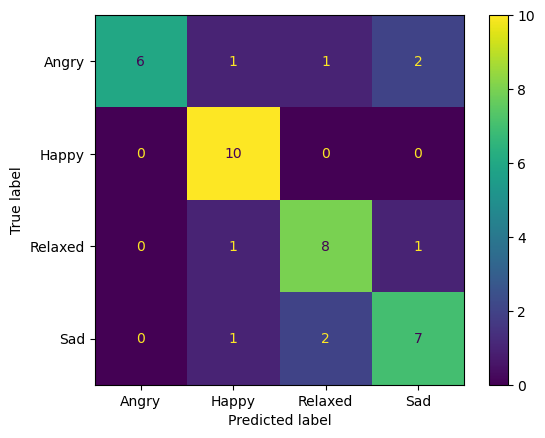

In [212]:
print(classification_report(y2_test_spec, y2_pred, target_names = ['Angry', 'Happy', 'Relaxed', 'Sad']))
cm_2d_spec.plot()
plt.show()

### 4.3 mel spectrogram

In [101]:
# Load mel data set
mel1_file = np.load("Features2D/npz_new/mel1_train_test.npz")

mel1_train = mel1_file['mel_train']
y1_train = mel1_file['y_train']
mel1_train,mel1_val,y1_train,y1_val = train_test_split(mel1_train,y1_train, 
                                                       train_size = 0.8, 
                                                       random_state = 13, 
                                                       stratify= y1_train)

In [102]:
# Feature Scaling
mel1_train_scaled = (mel1_train - np.mean(mel1_train))/np.std(mel1_train)
mel1_val_scaled = (mel1_val - np.mean(mel1_val))/np.std(mel1_val)

In [103]:
# Reshape the data
N,row,col = mel1_train_scaled.shape
mel1_train_reshaped = mel1_train_scaled.reshape((N,row,col,1))

N,row,col = mel1_val_scaled.shape
mel1_val_reshaped = mel1_val_scaled.reshape((N,row,col,1))

In [104]:
f1,k1,a1 = 8,3,'relu'
mw1,mh1,sw1,sh1 = 2,3,2,2
f2,k2,a2 = 8,3,'relu'
mw2,mh2,sw2,sh2 = 2,3,2,2
f3,k3,a3 = 16,3,'relu'
mw3,mh3,sw3,sh3 = 2,3,2,2
d1,dr1,da1,r1 = 64,0.2,'relu',0.2
d2,dr2,da2,r2 = 32,0.2,'relu',0.2
num = 5
model5 = modelBuilder3L(mel1_train_reshaped,
                        f1,k1,a1,
                        mw1,mh1,sw1,sh1,
                        f2,k2,a2,
                        mw2,mh2,sw2,sh2,
                        f3,k3,a3,
                        mw3,mh3,sw3,sh3,
                        d1,dr1,da1,r1,
                        d2,dr2,da2,r2,
                        num)

Model: "CNN2D_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 300, 400, 8)       80        
                                                                 
 MaxPooling2D_1 (MaxPooling2  (None, 150, 200, 8)      0         
 D)                                                              
                                                                 
 BN1 (BatchNormalization)    (None, 150, 200, 8)       32        
                                                                 
 Conv2D_2 (Conv2D)           (None, 150, 200, 8)       584       
                                                                 
 MaxPooling2D_2 (MaxPooling2  (None, 75, 100, 8)       0         
 D)                                                              
                                                                 
 BN2 (BatchNormalization)    (None, 75, 100, 8)        32  

In [105]:
model5.fit(mel1_train_reshaped,y1_train,validation_data=(mel1_val_reshaped,y1_val),batch_size=20,epochs=80)

Epoch 1/80
29/29 [==============================] - 20s 618ms/step - loss: 33.4322 - accuracy: 0.3763 - val_loss: 30.8477 - val_accuracy: 0.2500
Epoch 2/80
29/29 [==============================] - 16s 541ms/step - loss: 28.2444 - accuracy: 0.4286 - val_loss: 26.0775 - val_accuracy: 0.2500
Epoch 3/80
29/29 [==============================] - 16s 549ms/step - loss: 23.6201 - accuracy: 0.4495 - val_loss: 22.5402 - val_accuracy: 0.2500
Epoch 4/80
29/29 [==============================] - 16s 538ms/step - loss: 20.0100 - accuracy: 0.4704 - val_loss: 19.8260 - val_accuracy: 0.2500
Epoch 5/80
29/29 [==============================] - 15s 534ms/step - loss: 17.1801 - accuracy: 0.4564 - val_loss: 17.0021 - val_accuracy: 0.2500
Epoch 6/80
29/29 [==============================] - 17s 588ms/step - loss: 14.9620 - accuracy: 0.4599 - val_loss: 15.8493 - val_accuracy: 0.2500
Epoch 7/80
29/29 [==============================] - 16s 538ms/step - loss: 13.2009 - accuracy: 0.5348 - val_loss: 13.5176 - val_ac

Epoch 58/80
29/29 [==============================] - 14s 488ms/step - loss: 1.5449 - accuracy: 0.9547 - val_loss: 2.4790 - val_accuracy: 0.5417
Epoch 59/80
29/29 [==============================] - 14s 489ms/step - loss: 1.4881 - accuracy: 0.9634 - val_loss: 2.4589 - val_accuracy: 0.5625
Epoch 60/80
29/29 [==============================] - 14s 498ms/step - loss: 1.4355 - accuracy: 0.9791 - val_loss: 2.3801 - val_accuracy: 0.5556
Epoch 61/80
29/29 [==============================] - 14s 495ms/step - loss: 1.3852 - accuracy: 0.9704 - val_loss: 2.3123 - val_accuracy: 0.5486
Epoch 62/80
29/29 [==============================] - 14s 490ms/step - loss: 1.3557 - accuracy: 0.9739 - val_loss: 2.3460 - val_accuracy: 0.5139
Epoch 63/80
29/29 [==============================] - 14s 498ms/step - loss: 1.2985 - accuracy: 0.9774 - val_loss: 2.2120 - val_accuracy: 0.5625
Epoch 64/80
29/29 [==============================] - 14s 492ms/step - loss: 1.2671 - accuracy: 0.9808 - val_loss: 2.3168 - val_accuracy:

In [185]:
# Load mel data set
mel2_file = np.load("Features2D/npz_new/mel2_train_test.npz")

mel2_train = mel2_file['mel_train']
y2_train = mel2_file['y_train']
mel2_train,mel2_val,y2_train,y2_val = train_test_split(mel2_train,y2_train, 
                                                       train_size = 0.8, 
                                                       random_state = 13, 
                                                       stratify= y2_train)

In [186]:
# Feature Scaling
mel2_train_scaled = (mel2_train - np.mean(mel2_train)) / np.std(mel2_train)
mel2_val_scaled = (mel2_val - np.amin(mel2_val)) / np.std(mel2_val)

In [187]:
# Reshape the data
N,row,col = mel2_train_scaled.shape
mel2_train_reshaped = mel2_train_scaled.reshape((N,row,col,1))

N,row,col = mel2_val_scaled.shape
mel2_val_reshaped = mel2_val_scaled.reshape((N,row,col,1))

In [190]:
f1,k1,a1 = 8,3,'relu'
mw1,mh1,sw1,sh1 = 2,3,2,2
f2,k2,a2 = 8,3,'relu'
mw2,mh2,sw2,sh2 = 2,3,2,2
f3,k3,a3 = 16,3,'relu'
mw3,mh3,sw3,sh3 = 2,3,2,2
d1,dr1,da1,r1 = 64,0.2,'relu',0.2
d2,dr2,da2,r2 = 32,0.2,'relu',0.2
num = 6
model6 = modelBuilder3L(mel2_train_reshaped,
                        f1,k1,a1,
                        mw1,mh1,sw1,sh1,
                        f2,k2,a2,
                        mw2,mh2,sw2,sh2,
                        f3,k3,a3,
                        mw3,mh3,sw3,sh3,
                        d1,dr1,da1,r1,
                        d2,dr2,da2,r2,
                        num)

Model: "CNN2D_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 300, 400, 8)       80        
                                                                 
 MaxPooling2D_1 (MaxPooling2  (None, 150, 200, 8)      0         
 D)                                                              
                                                                 
 BN1 (BatchNormalization)    (None, 150, 200, 8)       32        
                                                                 
 Conv2D_2 (Conv2D)           (None, 150, 200, 8)       584       
                                                                 
 MaxPooling2D_2 (MaxPooling2  (None, 75, 100, 8)       0         
 D)                                                              
                                                                 
 BN2 (BatchNormalization)    (None, 75, 100, 8)        32  

In [191]:
history6 = model6.fit(mel2_train_reshaped,y2_train,validation_data=(mel2_val_reshaped,y2_val),batch_size=20,epochs=80)

Epoch 1/80
15/15 [==============================] - 9s 487ms/step - loss: 34.4852 - accuracy: 0.4028 - val_loss: 32.8842 - val_accuracy: 0.3333
Epoch 2/80
15/15 [==============================] - 7s 469ms/step - loss: 31.3075 - accuracy: 0.5799 - val_loss: 29.9567 - val_accuracy: 0.4444
Epoch 3/80
15/15 [==============================] - 7s 466ms/step - loss: 28.3307 - accuracy: 0.6528 - val_loss: 27.2558 - val_accuracy: 0.4028
Epoch 4/80
15/15 [==============================] - 7s 441ms/step - loss: 25.7098 - accuracy: 0.7118 - val_loss: 24.9205 - val_accuracy: 0.3611
Epoch 5/80
15/15 [==============================] - 7s 440ms/step - loss: 23.3306 - accuracy: 0.7361 - val_loss: 22.8316 - val_accuracy: 0.3472
Epoch 6/80
15/15 [==============================] - 7s 474ms/step - loss: 21.2054 - accuracy: 0.8090 - val_loss: 21.2608 - val_accuracy: 0.2639
Epoch 7/80
15/15 [==============================] - 8s 509ms/step - loss: 19.4109 - accuracy: 0.8403 - val_loss: 19.8724 - val_accuracy:

Text(0, 0.5, 'loss')

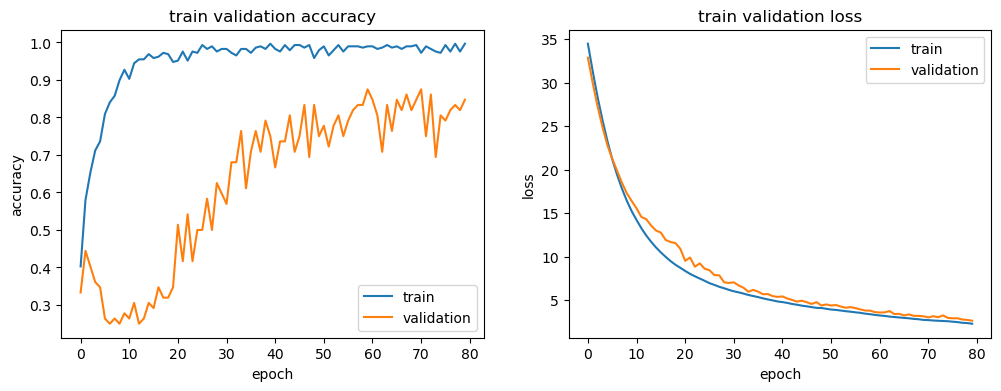

In [192]:
# Train and Validation accuracy and loss
f = plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.title('train validation accuracy')
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(1,2,2)
plt.title('train validation loss')
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

In [193]:
mel2_test = mel2_file['mel_test']
y2_test_mel = mel2_file['y_test']

In [194]:
# Feature Scaling
mel2_test_scaled = (mel2_test - np.mean(mel2_test)) / np.std(mel2_test)

# Reshape the data
N,row,col = mel2_test_scaled.shape
mel2_test_reshaped = mel2_test_scaled.reshape((N,row,col,1))

In [195]:
y3_prob = model6.predict(mel2_test_reshaped)
y3_pred = np.argmax(y3_prob, axis = -1)

2/2 [==============================] - 0s 60ms/step


In [196]:
# Accuracy
acc3_2d = round(accuracy_score(y3_pred,y2_test_mel),2)

In [197]:
# Confusion Matrix
cm_mel = confusion_matrix(y2_test_mel,y3_pred)
cm_2d_mel = ConfusionMatrixDisplay(confusion_matrix = cm_mel, display_labels = ['Angry', 'Happy', 'Relaxed', 'Sad'])

              precision    recall  f1-score   support

       Angry       0.91      1.00      0.95        10
       Happy       1.00      0.90      0.95        10
     Relaxed       0.82      0.90      0.86        10
         Sad       0.89      0.80      0.84        10

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



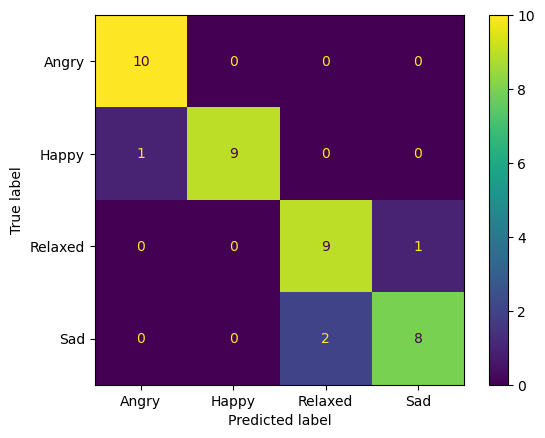

In [198]:
print(classification_report(y2_test_mel, y3_pred, target_names = ['Angry', 'Happy', 'Relaxed', 'Sad']))
cm_2d_mel.plot()
plt.show()

In [220]:
model2.save(os.getcwd() + "/Features2D/Model/Conv2D_mfcc.h5") 
model4.save(os.getcwd() + "/Features2D/Model/Conv2D_spec.h5") 
model6.save(os.getcwd() + "/Features2D/Model/Conv2D_mel.h5") 

## 5. Ensemble 3 models

In [221]:
spec_file_ense = np.load(os.getcwd() + "/Features2D/npz_new/spec2_train_test.npz")
spec_ense_train = spec_file_ense['spec_train']
spec_ense_test = spec_file_ense['spec_test']
y_ense_train = spec_file_ense['y_train']
y_ense_test = spec_file_ense['y_test']
model_spec = load_model(os.getcwd() + "/Features2D/Model/Conv2D_spec.h5")

In [222]:
mfcc_file_ense = np.load(os.getcwd() + "/Features2D/npz_new/mfcc2_train_test.npz")
mfcc_ense_train = mfcc_file_ense['mfcc_train']
mfcc_ense_test =mfcc_file_ense['mfcc_test']
y1_ense_train = mfcc_file_ense['y_train']
y1_ense_test = mfcc_file_ense['y_test']
model_mfcc = load_model(os.getcwd() + "/Features2D/Model/Conv2D_mfcc.h5")

In [223]:
mel_file_ense = np.load(os.getcwd() + "/Features2D/npz_new/mel2_train_test.npz")
mel_ense_train = mel_file_ense['mel_train']
mel_ense_test =mel_file_ense['mel_test']
y_ense_train = mel_file_ense['y_train']
y_ense_test = mel_file_ense['y_test']
model_mel = load_model(os.getcwd() + "/Features2D/Model/Conv2D_mel.h5")

In [224]:
# Feature Scaling
mfcc_ense_train_scaled = (mfcc_ense_train - np.mean(mfcc_ense_train))/np.std(mfcc_ense_train)
spec_ense_train_scaled = spec_ense_train / np.amax(spec_ense_train)
mel_ense_train_scaled = (mel_ense_train - np.mean(mel_ense_train))/np.std(mel_ense_train)

mfcc_ense_test_scaled = (mfcc_ense_test - np.mean(mfcc_ense_test))/np.std(mfcc_ense_test)
spec_ense_test_scaled = spec_ense_test / np.amax(spec_ense_test)
mel_ense_test_scaled = (mel_ense_test - np.mean(mel_ense_test))/np.std(mfcc_ense_test)


# Reshape the data
N,row,col = mfcc_ense_train_scaled.shape
mfcc_ense_train_reshaped = mfcc_ense_train_scaled.reshape((N,row,col,1))
N,row,col = spec_ense_train_scaled.shape
spec_ense_train_reshaped = spec_ense_train_scaled.reshape((N,row,col,1))
N,row,col = mel_ense_train_scaled.shape
mel_ense_train_reshaped = mel_ense_train_scaled.reshape((N,row,col,1))

N,row,col = mfcc_ense_test_scaled.shape
mfcc_ense_test_reshaped = mfcc_ense_test_scaled.reshape((N,row,col,1))
N,row,col = spec_ense_test_scaled.shape
spec_ense_test_reshaped = spec_ense_test_scaled.reshape((N,row,col,1))
N,row,col = mel_ense_test_scaled.shape
mel_ense_test_reshaped = mel_ense_test_scaled.reshape((N,row,col,1))

In [225]:
# Vote for most accuracte prediction
def get_majority(pred) :
    N = len(pred[0])
    vote = []
    for i in range(N) :
        elements = [j[i] for j in pred]
        elements = np.array(elements)
        uniq, freq = np.unique(elements, return_counts= True)
        vote.append(uniq[np.argmax(freq)])
    
    vote = np.array(vote)
    return vote

In [234]:
# Train 3 models
y_ense_prob1 = model_spec.predict(spec_ense_train_reshaped)
y_ense_pred1 = np.argmax(y_ense_prob1, axis= -1)

y_ense_prob2 = model_mfcc.predict(mfcc_ense_train_reshaped)
y_ense_pred2 = np.argmax(y_ense_prob2, axis= -1)

y_ense_prob3 = model_mel.predict(mel_ense_train_reshaped)
y_ense_pred3 = np.argmax(y_ense_prob3, axis= -1)

12/12 [==============================] - 3s 210ms/step


In [235]:
# 3 different predictions
train_pred = [y_ense_pred1, y_ense_pred2, y_ense_pred3]

In [236]:
y_train_pred = get_majority(train_pred)

In [237]:
# Model Evaluation
train_corr = len(y_train_pred) - np.count_nonzero(y_train_pred - y_ense_train)
train_acc = np.round((train_corr/ len(y_train_pred)),4)
train_acc

0.9722

In [238]:
# Test ensembled models
y_test_prob1 = model_spec.predict(spec_ense_test_reshaped)
y_test_pred1 = np.argmax(y_test_prob1, axis= -1)

y_test_prob2 = model_mfcc.predict(mfcc_ense_test_reshaped)
y_test_pred2 = np.argmax(y_test_prob2, axis= -1)

y_test_prob3 = model_mel.predict(mel_ense_test_reshaped)
y_test_pred3 = np.argmax(y_test_prob3, axis= -1)

2/2 [==============================] - 0s 64ms/step


In [239]:
test_pred = [y_test_pred1, y_test_pred2, y_test_pred3]

In [240]:
y_test_pred = get_majority(test_pred)

In [241]:
# Model Evaluation
test_corr = len(y_test_pred) - np.count_nonzero(y_test_pred - y_ense_test)
test_acc = np.round((test_corr/ len(y_test_pred)),4)
test_acc

0.825

              precision    recall  f1-score   support

       Angry       0.71      1.00      0.83        10
       Happy       0.91      1.00      0.95        10
     Relaxed       0.80      0.80      0.80        10
         Sad       1.00      0.50      0.67        10

    accuracy                           0.82        40
   macro avg       0.86      0.82      0.81        40
weighted avg       0.86      0.82      0.81        40



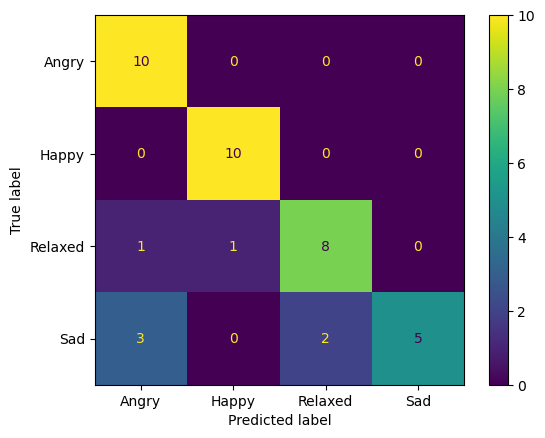

In [242]:
# Confusion Matrix
cm_ense = confusion_matrix(y_ense_test,y_test_pred)
cm_display_ense = ConfusionMatrixDisplay(confusion_matrix = cm_ense, display_labels = ['Angry', 'Happy', 'Relaxed', 'Sad'])
print(classification_report(y_ense_test, y_test_pred, target_names = ['Angry', 'Happy', 'Relaxed', 'Sad']))
cm_display_ense.plot()
plt.show()